In [1]:
#Importing Libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras import layers, optimizers, callbacks  
from sklearn.utils.class_weight import compute_class_weight  
import gradio as gr
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
#Extracting Data
zip_path = "dataset.zip"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

data_path = "garbage_classification"
print("✅ Dataset extracted.")

✅ Dataset extracted.



Showing samples for class: battery


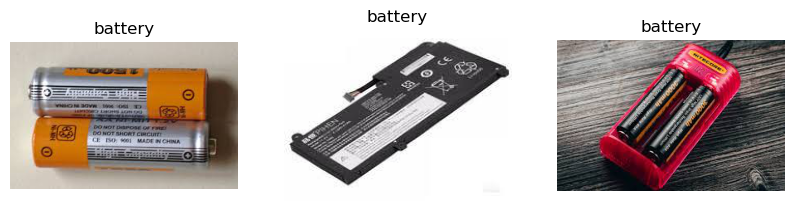


Showing samples for class: biological


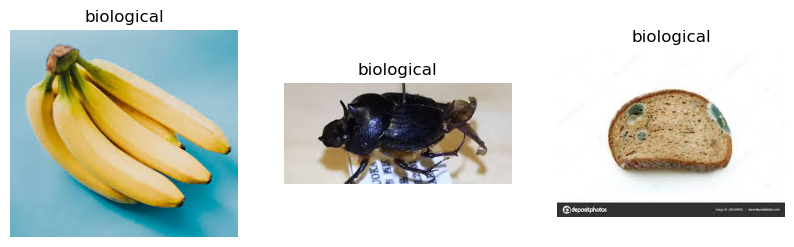


Showing samples for class: brown-glass


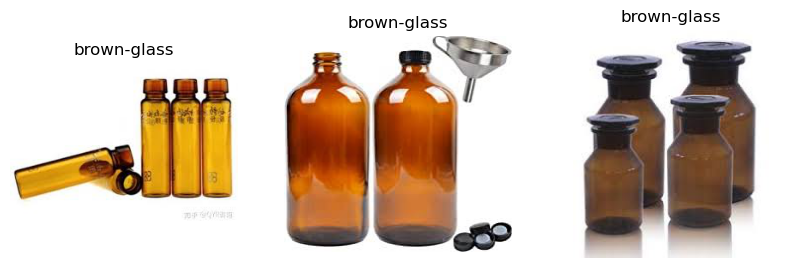


Showing samples for class: cardboard


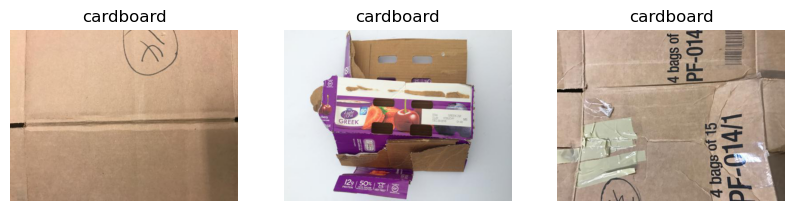


Showing samples for class: clothes


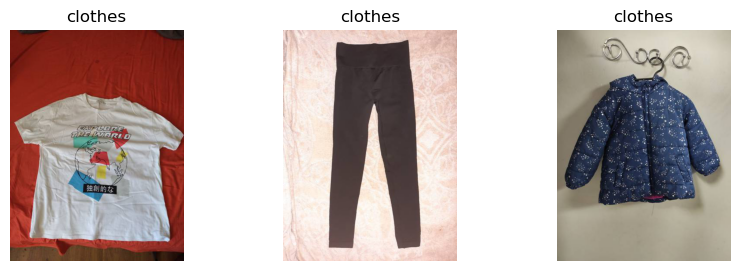


Showing samples for class: green-glass


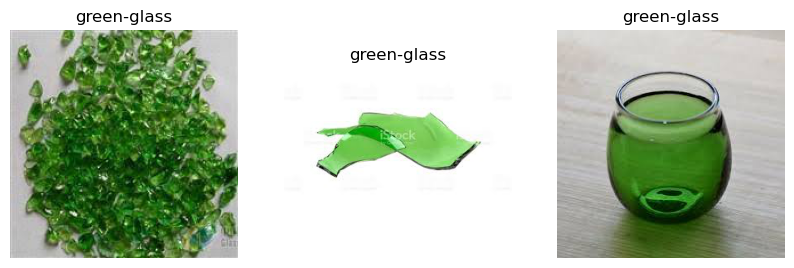


Showing samples for class: metal


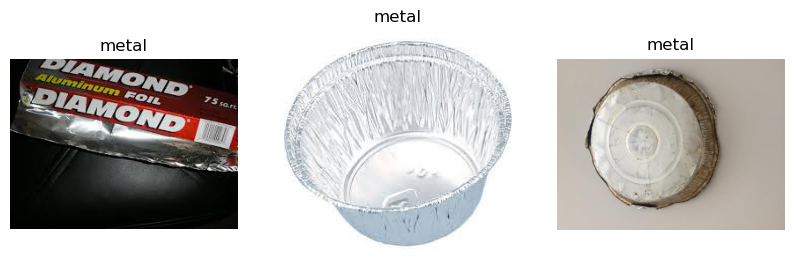


Showing samples for class: paper


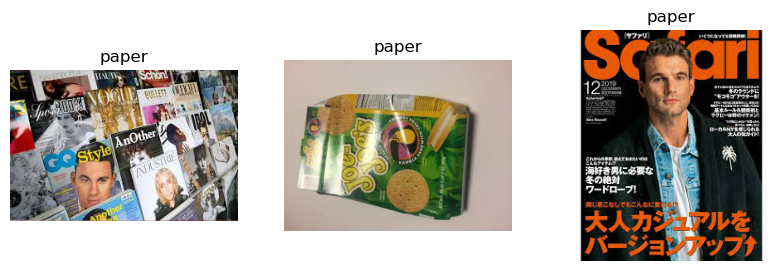


Showing samples for class: plastic


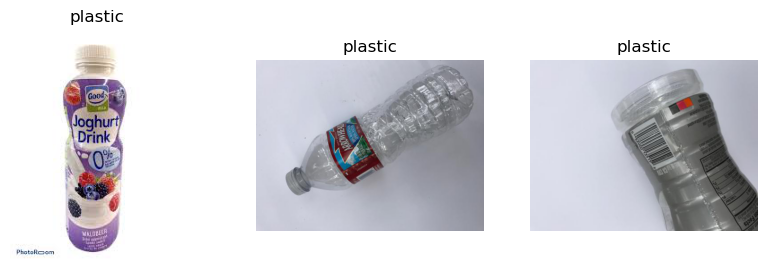


Showing samples for class: shoes


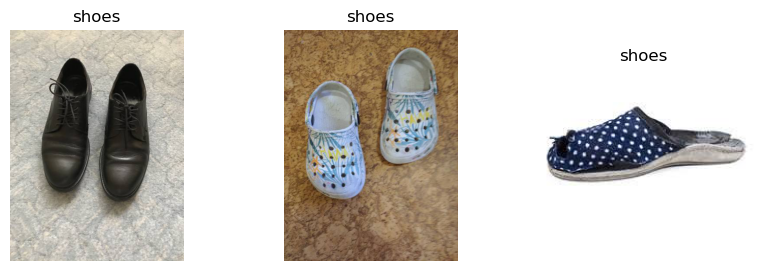


Showing samples for class: trash


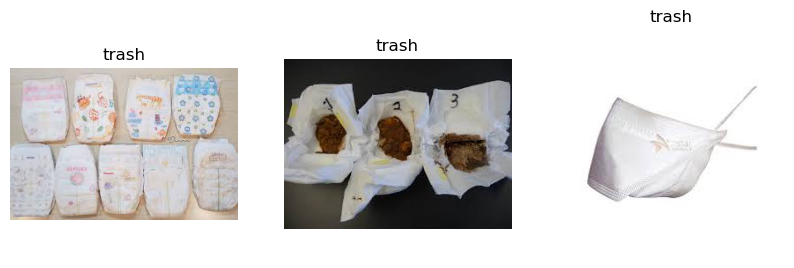


Showing samples for class: white-glass


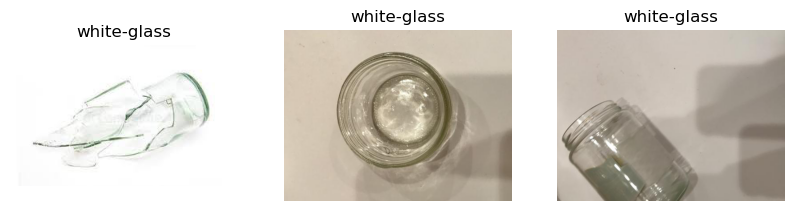

In [3]:
#View Samples
classes = os.listdir(data_path)

for class_name in classes:
    class_folder = os.path.join(data_path, class_name)
    image_files = os.listdir(class_folder)[:3]

    print(f"\nShowing samples for class: {class_name}")
    plt.figure(figsize=(10, 3))

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(class_folder, img_name)
        img = plt.imread(img_path)

        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

    plt.show()

In [4]:
#Preprocessing and datasplit
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


{'battery': 945, 'biological': 985, 'brown-glass': 607, 'cardboard': 891, 'clothes': 5325, 'green-glass': 629, 'metal': 769, 'paper': 1050, 'plastic': 865, 'shoes': 1977, 'trash': 697, 'white-glass': 775}


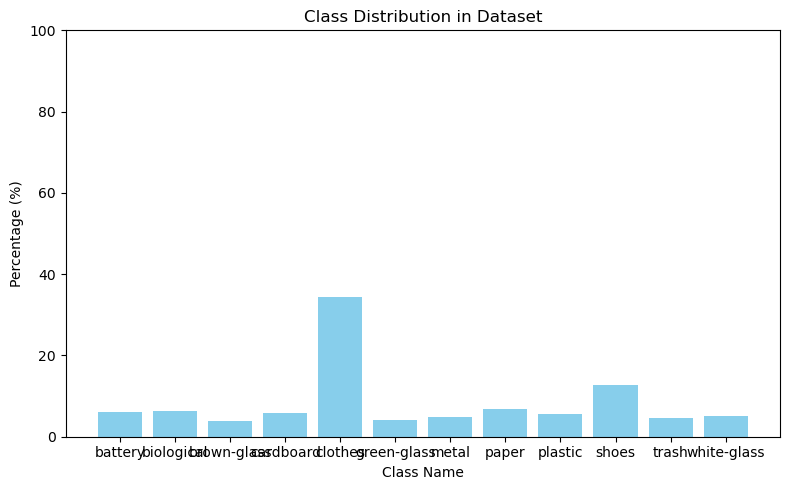

Class image counts: {'battery': 6.09, 'biological': 6.35, 'brown-glass': 3.91, 'cardboard': 5.74, 'clothes': 34.32, 'green-glass': 4.05, 'metal': 4.96, 'paper': 6.77, 'plastic': 5.58, 'shoes': 12.74, 'trash': 4.49, 'white-glass': 5.0}


In [5]:
#Class distribution
class_counts = {}
total=0
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))
        total+=len(os.listdir(class_folder))

print(class_counts)
for k in class_counts:
    class_counts[k]=round((class_counts[k]/total)*100,2)

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution in Dataset")
plt.xlabel("Class Name")
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

print("Class image counts:", class_counts)


In [6]:
labels = train_generator.classes  # auto-generated labels from folder names
class_names = list(train_generator.class_indices.keys())

# Compute weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights_array))
print("Computed class weights:", class_weights)

Computed class weights: {0: 1.3684964726631392, 1: 1.3129230118443316, 2: 2.128772290809328, 3: 1.451028517999065, 4: 0.24285993740219092, 5: 2.052744708994709, 6: 1.6795183982683983, 7: 1.2316468253968254, 8: 1.4950626204238922, 9: 0.6539717656974294, 10: 1.8540919952210275, 11: 1.6686827956989247}


In [7]:
#Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [8]:
#Load the predefined model
base_model = EfficientNetV2B3(
    include_top=False, 
    input_shape=(300, 300, 3),
    include_preprocessing=True, 
    weights='imagenet'
)

base_model.trainable=False



In [9]:
#Creating model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),             
    Dropout(0.3),                         
    Dense(128, activation='relu'),       
    Dense(train_generator.num_classes, activation='softmax')
])

In [10]:
#Comppile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
#Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.8446 - loss: 0.6984 - val_accuracy: 0.9452 - val_loss: 0.1780
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.9569 - loss: 0.1616 - val_accuracy: 0.9529 - val_loss: 0.1610
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.9639 - loss: 0.1376 - val_accuracy: 0.9461 - val_loss: 0.1668
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 732s 2s/step - accuracy: 0.9681 - loss: 0.1217 - val_accuracy: 0.9565 - val_loss: 0.1434
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.9735 - loss: 0.1001 - val_accuracy: 0.9558 - val_loss: 0.1490
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 821s 2s/step - accuracy: 0.9759 - loss: 0.0861 - val_accuracy: 0.9574 - val_loss: 0.1456
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 781s 2s/step - accuracy: 0.9805 - loss: 0.0758 - val_accuracy: 0.9594 - val_loss: 0.1444


In [12]:

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)       │ (None, 10, 10, 1536)        │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,525,476 (51.60 MB)

 Trainable params: 198,284 (774.55 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

 Optimizer params: 396,570 (1.51 MB)

In [13]:
base_model.summary() 

Model: "efficientnetv2-b3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 300, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 300, 300, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 300, 300, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 150, 150, 40)      │           1,080 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 150, 150, 40)      │             160 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 150, 150, 40)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 150, 150, 16)      │           5,760 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 150, 150, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 150, 150, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 150, 150, 16)      │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 150, 150, 16)      │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 150, 150, 16)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 150, 150, 16)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 150, 150, 16)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 75, 75, 64)        │           9,21

 Total params: 12,930,622 (49.33 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,930,622 (49.33 MB)

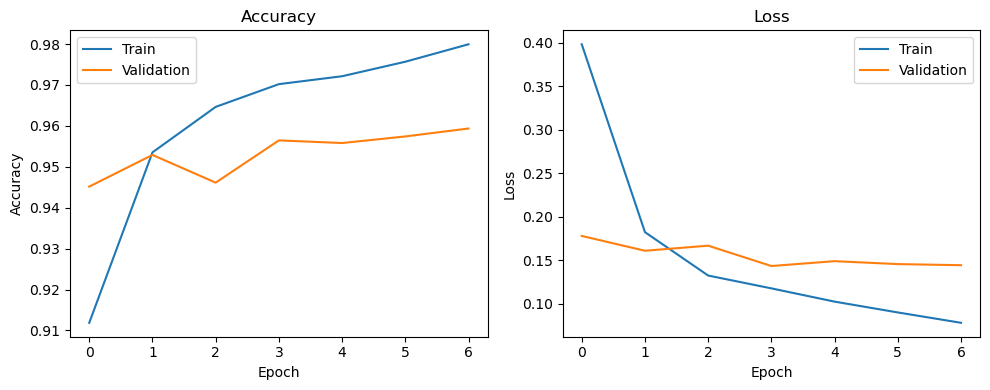

In [14]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Accuracy and Loss
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9799
Final Training Loss: 0.0781
Final Validation Accuracy: 0.9594
Final Validation Loss: 0.1444


In [16]:
y_probs = model.predict(val_generator, verbose=1)

y_pred = np.argmax(y_probs, axis=1)

y_true = val_generator.classes

class_names = list(val_generator.class_indices.keys())

97/97 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step


In [17]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

     battery       0.06      0.06      0.06       189
  biological       0.04      0.04      0.04       197
 brown-glass       0.04      0.04      0.04       121
   cardboard       0.05      0.05      0.05       178
     clothes       0.34      0.34      0.34      1065
 green-glass       0.03      0.02      0.02       125
       metal       0.07      0.07      0.07       153
       paper       0.09      0.10      0.10       210
     plastic       0.04      0.05      0.05       173
       shoes       0.10      0.11      0.11       395
       trash       0.06      0.06      0.06       139
 white-glass       0.05      0.05      0.05       155

    accuracy                           0.16      3100
   macro avg       0.08      0.08      0.08      3100
weighted avg       0.16      0.16      0.16      3100



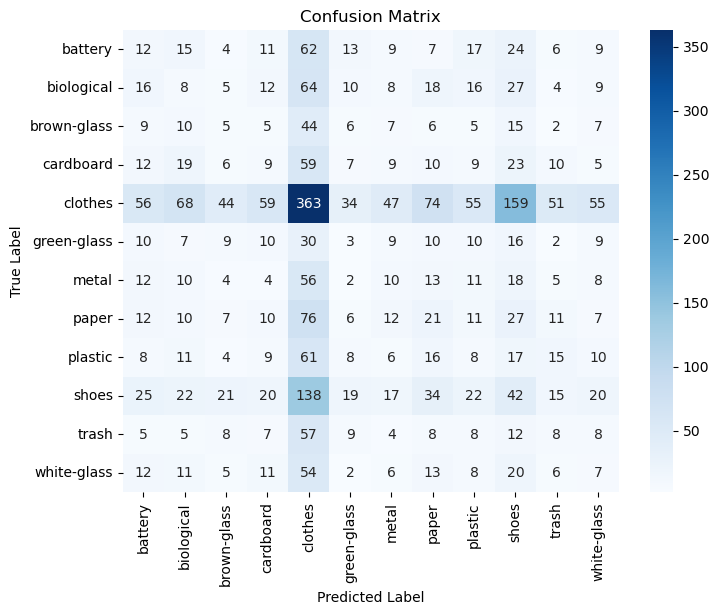

In [18]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


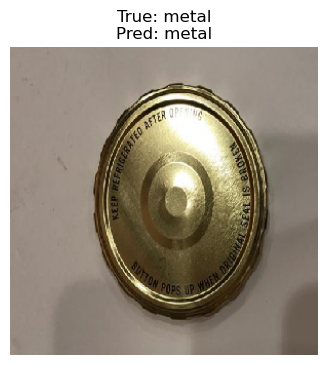

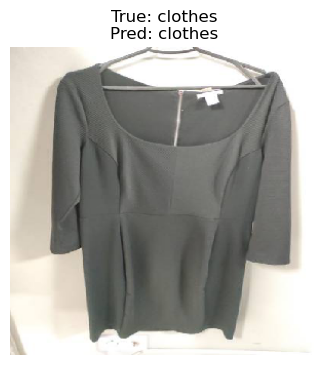

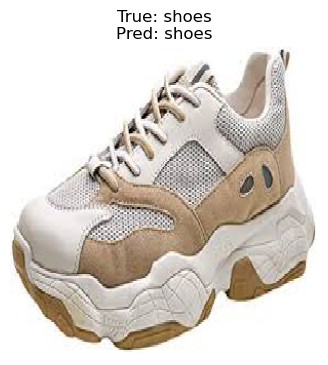

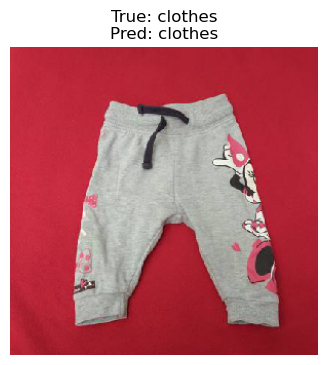

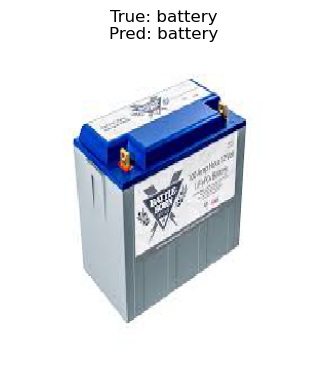

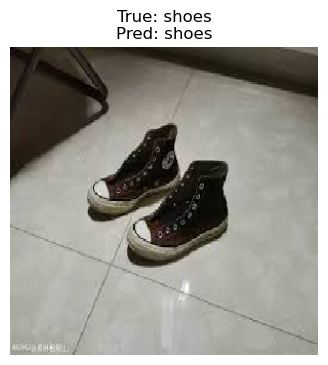

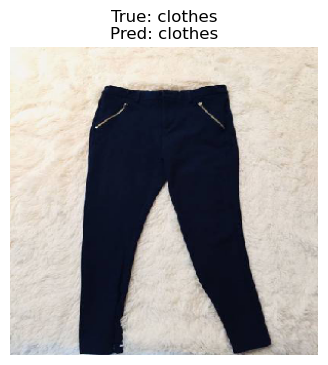

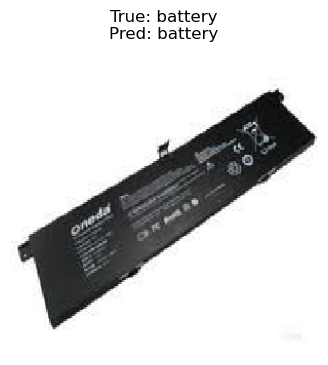

In [19]:
#Final test and predictions
class_names = list(train_generator.class_indices.keys())

images, labels = next(val_generator)

predictions = model.predict(images)

pred_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(labels, axis=1)

for i in range(8):
    plt.figure(figsize=(4, 4))
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis("off")
    plt.show()

In [20]:
#Saving as tflite model for android app integration
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('garbage_classifier_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpe0ajg4eo\assets


INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpe0ajg4eo\assets


Saved artifact at 'C:\Users\Dell\AppData\Local\Temp\tmpe0ajg4eo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='keras_tensor_409')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  2323423995728: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2323423996112: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2323423995536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323423994384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323423991120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323423994576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323423991504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323423990928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323423997648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323423994192: TensorSpec(shape=(), dtype=tf.resour

In [21]:
model.save('garbage_classifier_model.keras')

print("✅ Model saved successfully.")

model = tf.keras.models.load_model('garbage_classifier_model.keras')

print("✅ Model Loaded successfully.")

✅ Model saved successfully.
✅ Model Loaded successfully.


In [22]:
#Building a interface using gradio
!pip install gradio


Defaulting to user installation because normal site-packages is not writeable


In [23]:
def classify_image(img):  
    img = img.resize((300, 300))  
    
    img_array = np.array(img, dtype=np.float32)
    
    img_array = preprocess_input(img_array)
    
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_name = class_names[predicted_class_index]
    
    confidence = prediction[0][predicted_class_index]
    
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"


In [24]:
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Classification Model",
    description="Upload an image to classify the type of garbage."
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://8896c5c72bfd26ad7c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 1731, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\anyio\to_thread.py", line 56, in ru